In [241]:
import itertools
import functools
import os
import math

import pmdarima as pm
from pmdarima import model_selection

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Century Schoolbook']
rcParams['font.size'] = 14
rcParams['figure.dpi'] = 300
rcParams['text.usetex'] = False
from matplotlib.markers import CARETDOWNBASE, CARETUPBASE
import matplotlib.dates as mdates

import datetime as dt
from datetime import date, datetime, timedelta

import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

from ETL_utilities import it_data_load, fix_2020_03_10, add_delta_growth_perc, add_ra, add_ra_days
from formatting_utilities import format_dates, format_dates_from_numbers, LegendTitle
from file_utilities import save_in_dir
from common_data import REGIONS_POP

%load_ext autoreload
%autoreload 2

# Global constants
# PLEASE CUSTOMIZE
OUTPUT_PATH = '../output'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
# Caricamento dei dati dalla Protezione Civile
ds_it = it_data_load()

# Sanity check
ds_it.tail(10)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
data,,,,,,,,,,,,,,,
2020-04-29,ITA,19210,1795,21005,83652,104657,-548,2086,71252,27682,203591,1910761,1313460.0,NaN,NaN
2020-04-30,ITA,18149,1694,19843,81708,101551,-3106,1872,75945,27967,205463,1979217,1354901.0,NaN,NaN
2020-05-01,ITA,17569,1578,19147,81796,100943,-608,1965,78249,28236,207428,2053425,1398633.0,dc-IT-0015,dc-EN-0015
2020-05-02,ITA,17357,1539,18896,81808,100704,-239,1900,79914,28710,209328,2108837,1429864.0,dc-IT-0017,dc-EN-0017
2020-05-03,ITA,17242,1501,18743,81436,100179,-525,1389,81654,28884,210717,2153772,1456911.0,NaN,NaN
2020-05-04,ITA,16823,1479,18302,81678,99980,-199,1221,82879,29079,211938,2191403,1479910.0,dc-IT-0019,dc-EN-0019
2020-05-05,ITA,16270,1427,17697,80770,98467,-1513,1075,85231,29315,213013,2246666,1512121.0,NaN,NaN
2020-05-06,ITA,15769,1333,17102,74426,91528,-6939,1444,93245,29684,214457,2310929,1549892.0,dc-IT-0021,dc-EN-0021
2020-05-07,ITA,15174,1311,16485,73139,89624,-1904,1401,96276,29958,215858,2381288,1563557.0,dc-IT-0023,dc-EN-0023


In [243]:
# Correzione dati errati 2020-03-10 nazionali
fix_2020_03_10(ds_it)

In [244]:
add_delta_growth_perc(ds_it)
add_ra(ds_it)

In [245]:
# Check
#ds_it.head()
ds_it.loc[:, [
    'totale_casi', 'totale_casi_DELTA', 'totale_casi_DELTA_RA_7', 'tamponi', 'tamponi_DELTA', 'casi_testati_DELTA',
    'tamponi_negativi', 'dimessi_guariti', 'dimessi_guariti_DELTA', 'deceduti', 'deceduti_DELTA', 'positive_test_RATIO',
    'terapia_intensiva_RATIO', 'terapia_intensiva_CUM', 'totale_ospedalizzati_RATIO'
]].tail(10)

,totale_casi,totale_casi_DELTA,totale_casi_DELTA_RA_7,tamponi,tamponi_DELTA,casi_testati_DELTA,tamponi_negativi,dimessi_guariti,dimessi_guariti_DELTA,deceduti,deceduti_DELTA,positive_test_RATIO,terapia_intensiva_RATIO,terapia_intensiva_CUM,totale_ospedalizzati_RATIO
data,,,,,,,,,,,,,,,
2020-04-29,203591,2086.0,1996.714286,1910761,63827.0,38589.0,61741.0,71252,2311.0,27682,323.0,0.032682,0.017151,149447,0.200703
2020-04-30,205463,1872.0,1863.142857,1979217,68456.0,41441.0,66584.0,75945,4693.0,27967,285.0,0.027346,0.016681,151141,0.195399
2020-05-01,207428,1965.0,1789.142857,2053425,74208.0,43732.0,72243.0,78249,2304.0,28236,269.0,0.026480,0.015633,152719,0.189681
2020-05-02,209328,1900.0,1644.000000,2108837,55412.0,31231.0,53512.0,79914,1665.0,28710,474.0,0.034289,0.015282,154258,0.187639
2020-05-03,210717,1389.0,1552.285714,2153772,44935.0,27047.0,43546.0,81654,1740.0,28884,174.0,0.030911,0.014983,155759,0.187095
2020-05-04,211938,1221.0,1485.000000,2191403,37631.0,22999.0,36410.0,82879,1225.0,29079,195.0,0.032447,0.014793,157238,0.183057
2020-05-05,213013,1075.0,1393.857143,2246666,55263.0,32211.0,54188.0,85231,2352.0,29315,236.0,0.019452,0.014492,158665,0.179725
2020-05-06,214457,1444.0,1309.500000,2310929,64263.0,37771.0,62819.0,93245,8014.0,29684,369.0,0.022470,0.014564,159998,0.186850
2020-05-07,215858,1401.0,1293.600000,2381288,70359.0,13665.0,68958.0,96276,3031.0,29958,274.0,0.019912,0.014628,161309,0.183935


In [246]:
SUBTITLE = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR_ISTAT = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19; Istat - http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1\nCodice libero: https://github.com/emazep/COVID-19-Statistics'

common_plt_params = {'markersize':8, 'linewidth':4}
small_plt_params = {'markersize':6, 'linewidth':3}

DATE_SIZE = 9

GLOBAL_SLACK = 0.54
TAMPONI_MEAN_SLACK = 0.0064

pe_outline = pe.withStroke(linewidth=5, foreground='black')
pe_shadow = pe.SimpleLineShadow(offset=(0,-4), alpha=0.4)
pe_normal = pe.Normal()

In [247]:
MIN_DATE = ds_it.index.min()
MAX_DATE = ds_it.index.max()

def set_xlim(ax, x_axis, slack=0, min_date=MIN_DATE):
    ax.set_xlim(left=min_date, right=x_axis[-1])
    ax.set_xlim(ax.get_xlim()[0]-slack, ax.get_xlim()[1]+slack)

def set_xlim_num(ax, slack=0, min_x=0, max_x=200):
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_xlim(ax.get_xlim()[0]-slack, ax.get_xlim()[1]+slack)

In [261]:
ds = ds_it

def make_arima_pred(ds, column, periods=10, m=1):
    start_day = ds.index.max() + dt.timedelta(days=1)
    x_pred = pd.date_range(start=start_day, periods=periods)

    arima = pm.auto_arima(ds[column], suppress_warnings=True, m=m, stepwise=False, n_jobs=4, max_order=12, maxiter=200)
    predictions, conf_int = arima.predict(n_periods=periods, return_conf_int=True)
    return x_pred, predictions, conf_int

In [249]:
SUBTITLE = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19 (dati del 10/03/2020 corretti)\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19\nCodice libero: https://github.com/emazep/COVID-19-Statistics'
SUBTITLE_NO_CORR_ISTAT = 'Fonte: Protezione Civile Italia - https://github.com/pcm-dpc/COVID-19; Istat - http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1\nCodice libero: https://github.com/emazep/COVID-19-Statistics'

common_plt_params = {'markersize':8, 'linewidth':4}
small_plt_params = {'markersize':6, 'linewidth':3}

DATE_SIZE = 9

GLOBAL_SLACK = 0.54
TAMPONI_MEAN_SLACK = 0.0064

pe_outline = pe.withStroke(linewidth=5, foreground='black')
pe_shadow = pe.SimpleLineShadow(offset=(0,-4), alpha=0.4)
pe_normal = pe.Normal()

In [250]:
def plot_predictions(ds, column, x_axis, predictions, conf_int, suptitle, legend_title, y_major=500, y_minor=100, min_date=None):
    SLACK = 0.5
    ALPHA = 0.4

    last_date_str = ds.index.max().strftime('%d/%m/%Y')
    
    ax = ds.plot(y=column, label='Valori osservati', **common_plt_params, marker='o', figsize=(16, 8), zorder=3, color='tab:blue')
    ax.plot(x_axis, predictions, label='Valori predetti', **common_plt_params, marker='o', color='magenta')
    plt.fill_between(x_axis, conf_int[:, 0], conf_int[:, 1], alpha=0.4, color='limegreen', label='Intervallo di confidenza al 95%')

    #set_xlim(ax, SLACK)

    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_dates))
    ax.tick_params(axis='x', which='both', labelsize=DATE_SIZE)
    ax.xaxis.grid(True, which='both', alpha=ALPHA)

    ax.yaxis.grid(True, which='major', alpha=ALPHA)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(y_major))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:n}'))
    ax.tick_params(axis='y', which='both', labelsize=9)

    ax.tick_params(axis='y', which='both', right=True, labelright=True)

    plt.xlabel(None)

    set_xlim(ax, x_axis, SLACK, min_date=min_date if min_date else ds.index.min())
    ax.set_ylim(bottom=0)
    
    ax.legend(title='Previsione mediante ARIMA\n'+legend_title+'\nal '+last_date_str, fontsize=14)

    ax.set_title(SUBTITLE, fontsize=14)
    plt.suptitle('    Previsione '+suptitle+' COVID-19 al '+last_date_str, fontsize=22)

    plt.show()
    
    return plt.gcf()

In [251]:
# Docs on plotting ARIMA predictions & CI
'''
plt.plot(x_axis, predictions, marker='o', alpha=0.75)  # Forecasts
plt.scatter(ds.index, ds[column], alpha=0.4, marker='o')  # Test data
plt.fill_between(x_axis, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
plt.show()
'''

"\nplt.plot(x_axis, predictions, marker='o', alpha=0.75)  # Forecasts\nplt.scatter(ds.index, ds[column], alpha=0.4, marker='o')  # Test data\nplt.fill_between(x_axis, conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')\nplt.show()\n"

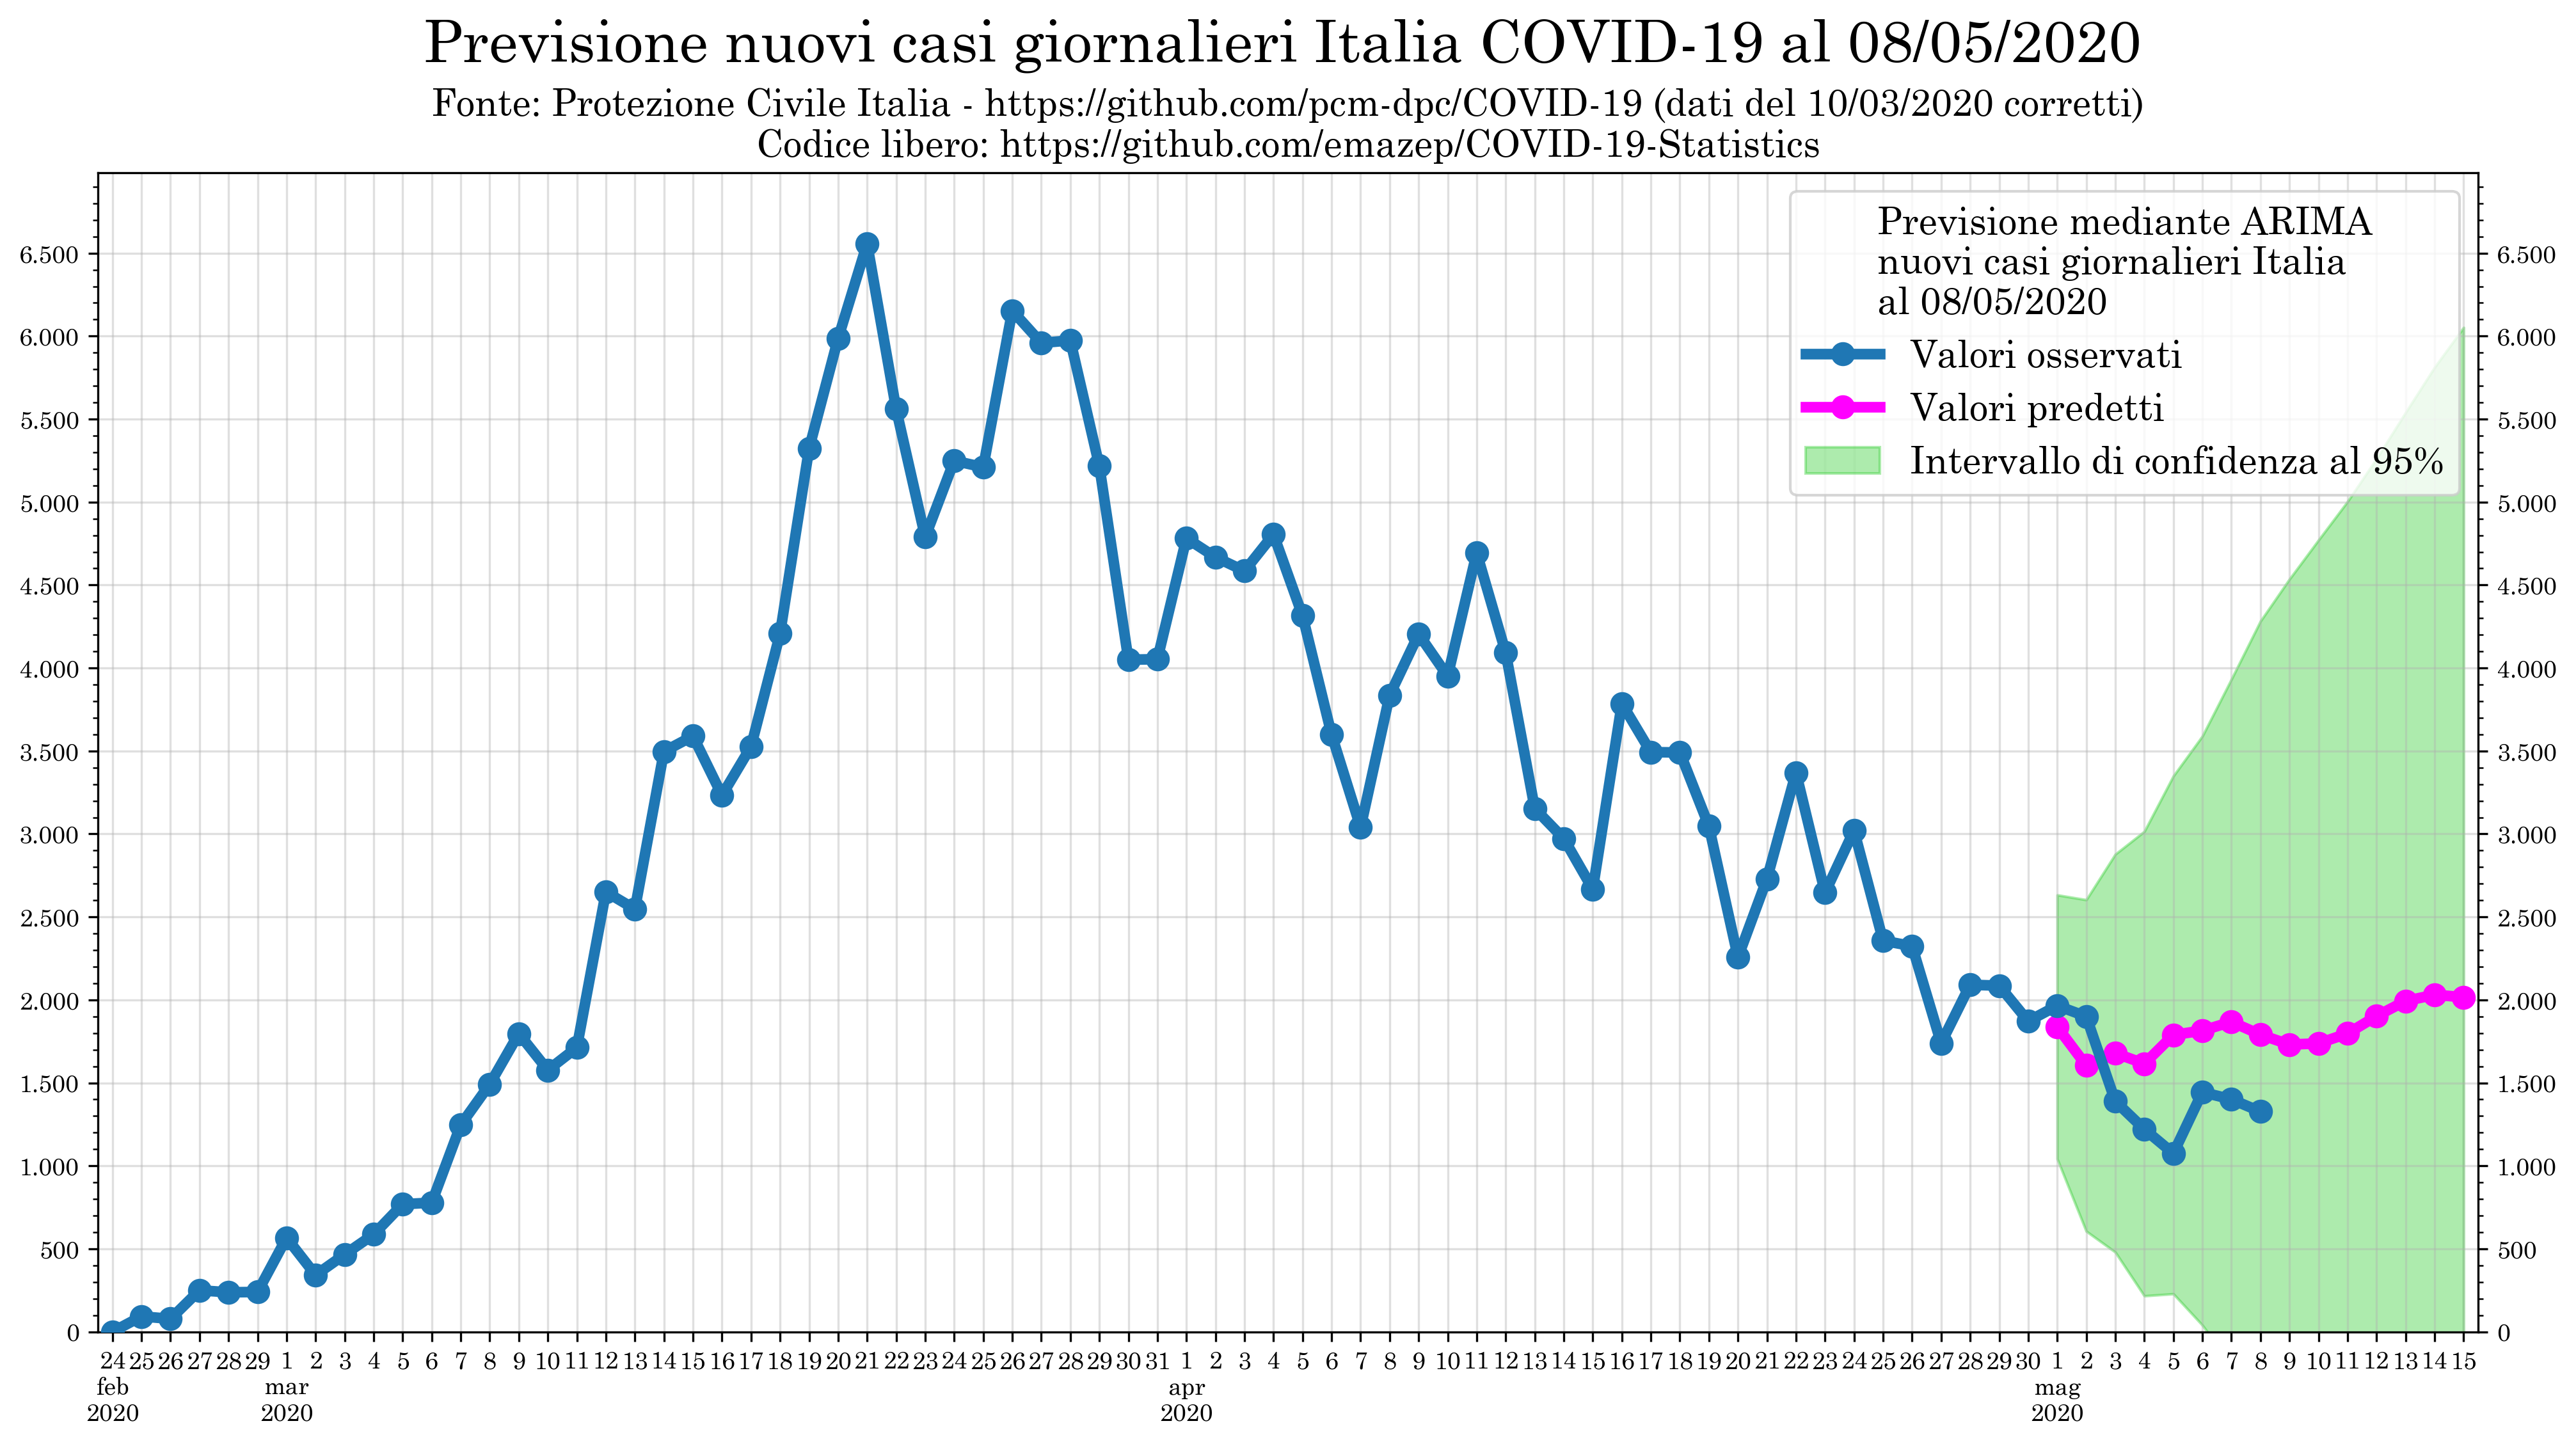

<Figure size 1800x1200 with 0 Axes>

In [269]:
FROM = date.fromisoformat('2020-03-21')
#ds = ds_it[FROM:]
ds = ds_it
column = 'totale_casi_DELTA'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=6, m=7)
fig_ARIMA_totale_casi_DELTA = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'nuovi casi giornalieri Italia', 'nuovi casi giornalieri Italia', y_major=500, y_minor=100
)

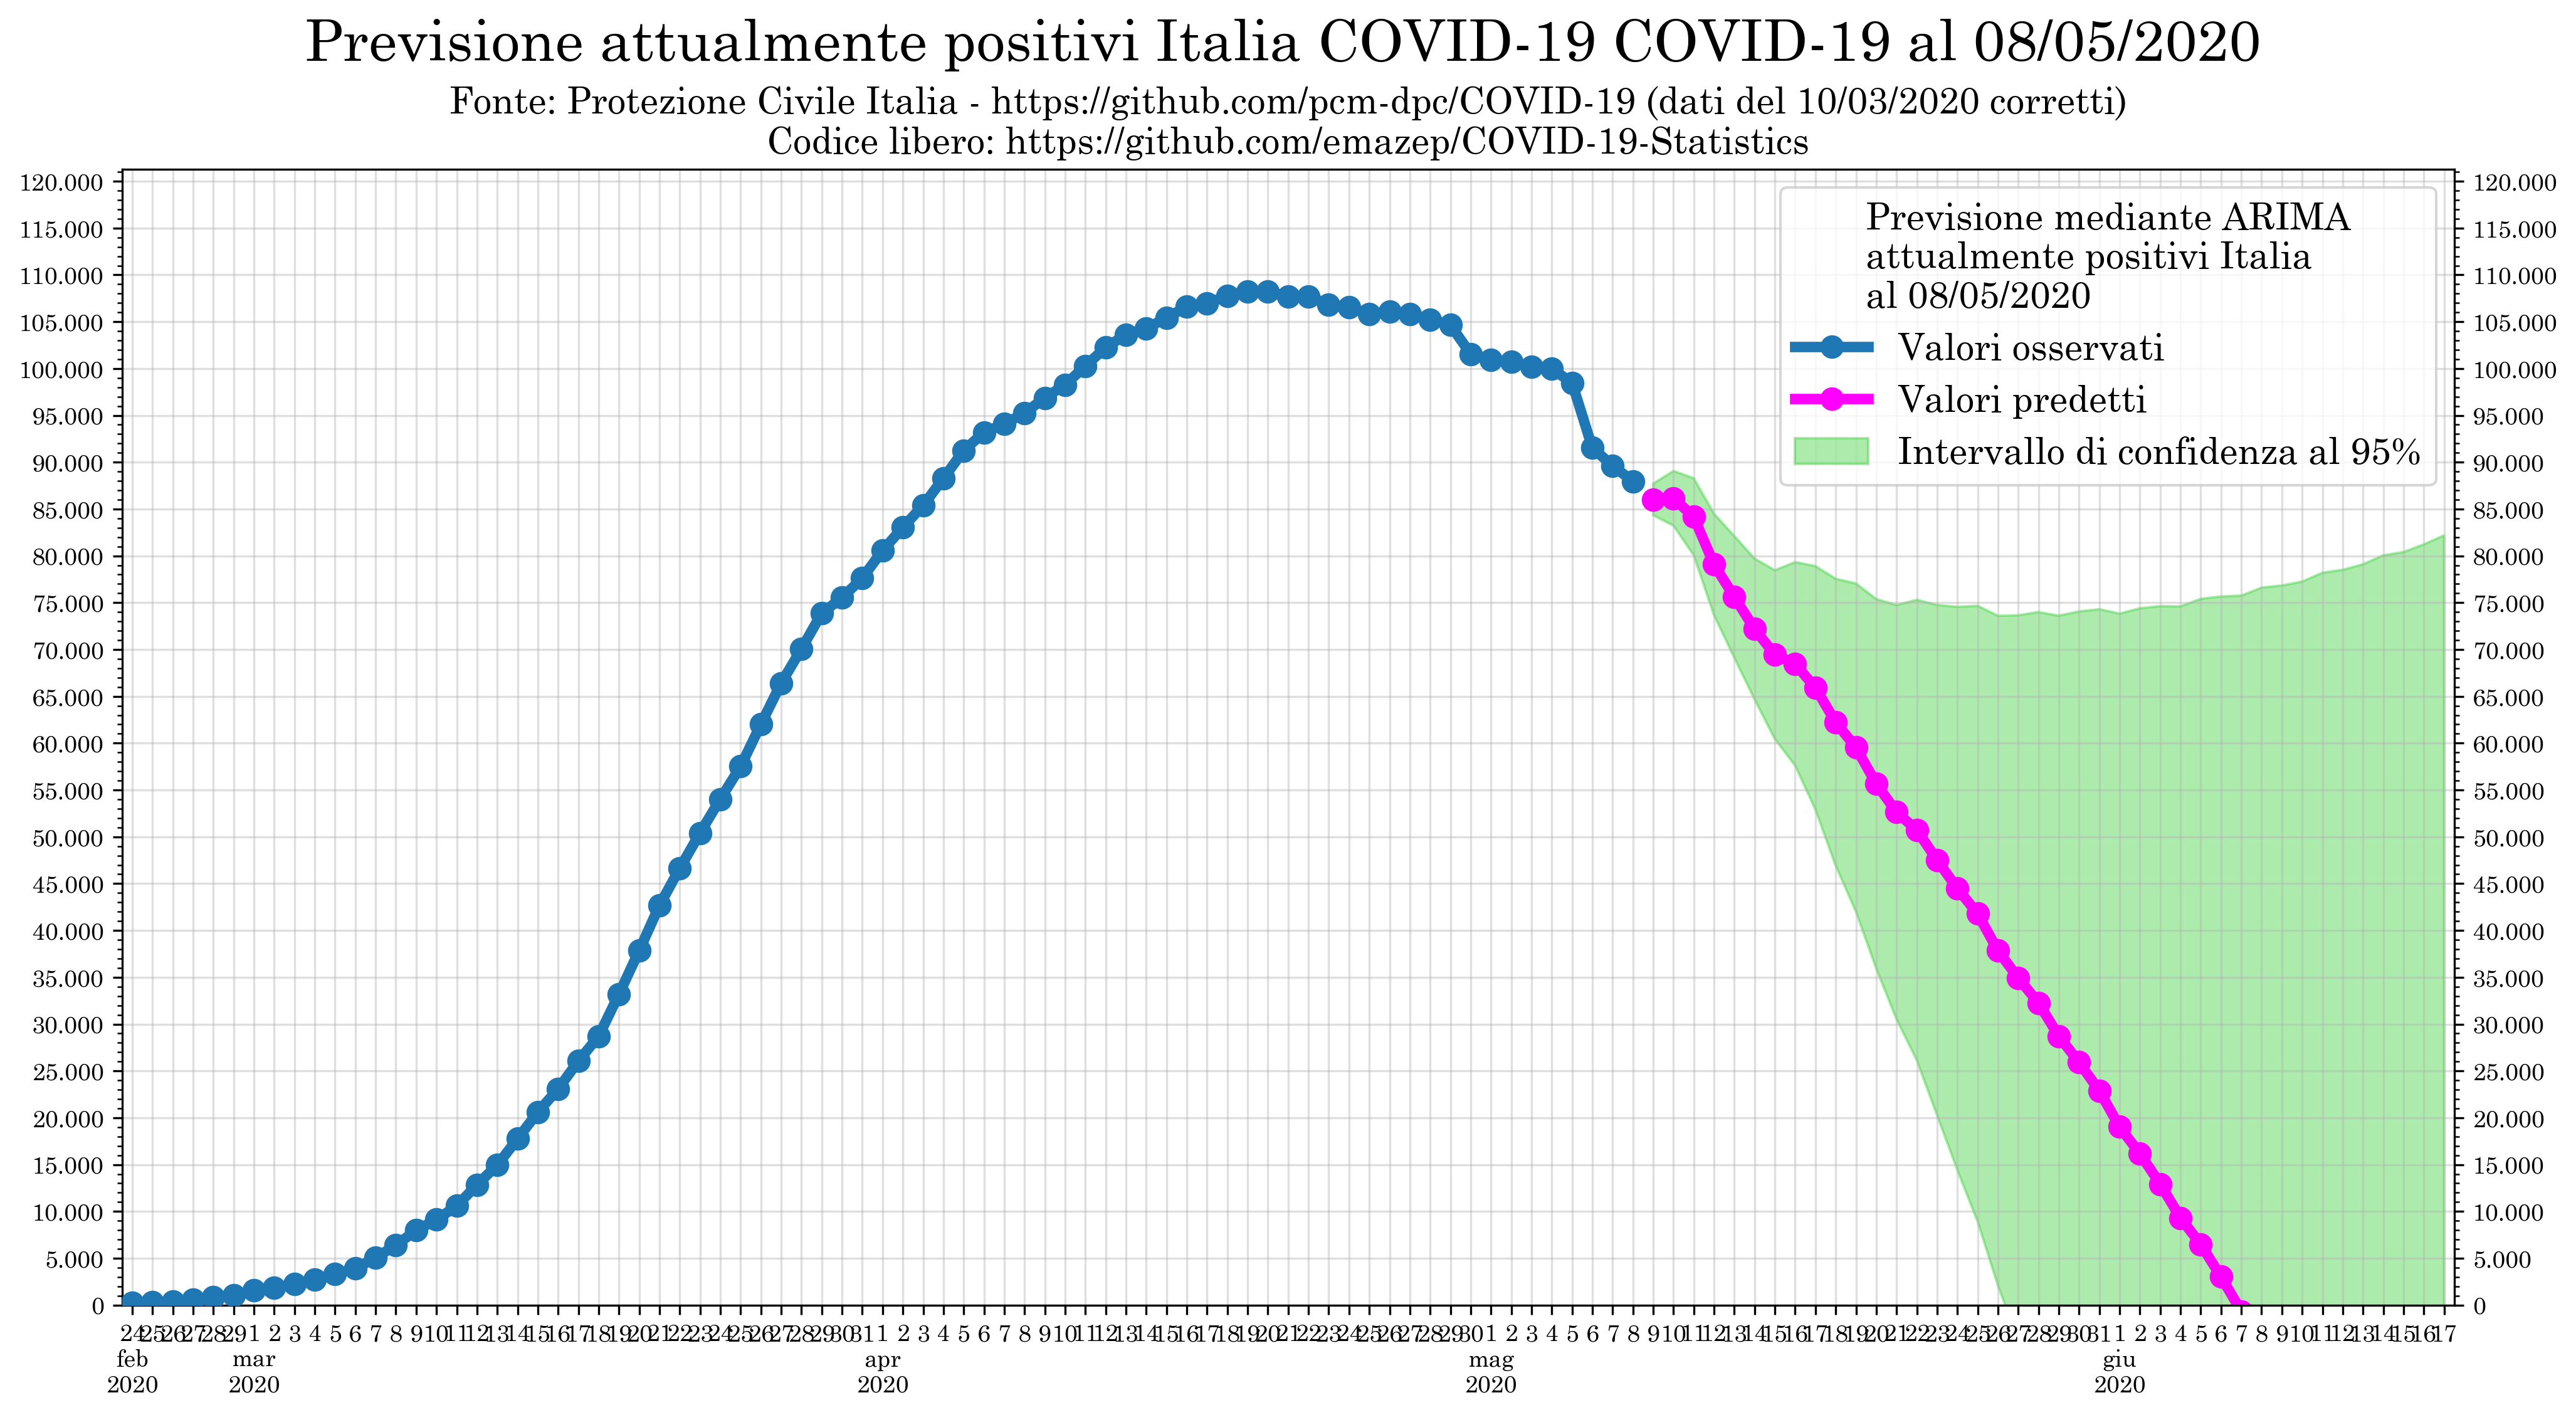

<Figure size 1800x1200 with 0 Axes>

In [270]:
ds = ds_it
column = 'totale_positivi'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=40)
fig_ARIMA_attualmente_positivi = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'attualmente positivi Italia COVID-19', 'attualmente positivi Italia', y_major=5000, y_minor=1000
)

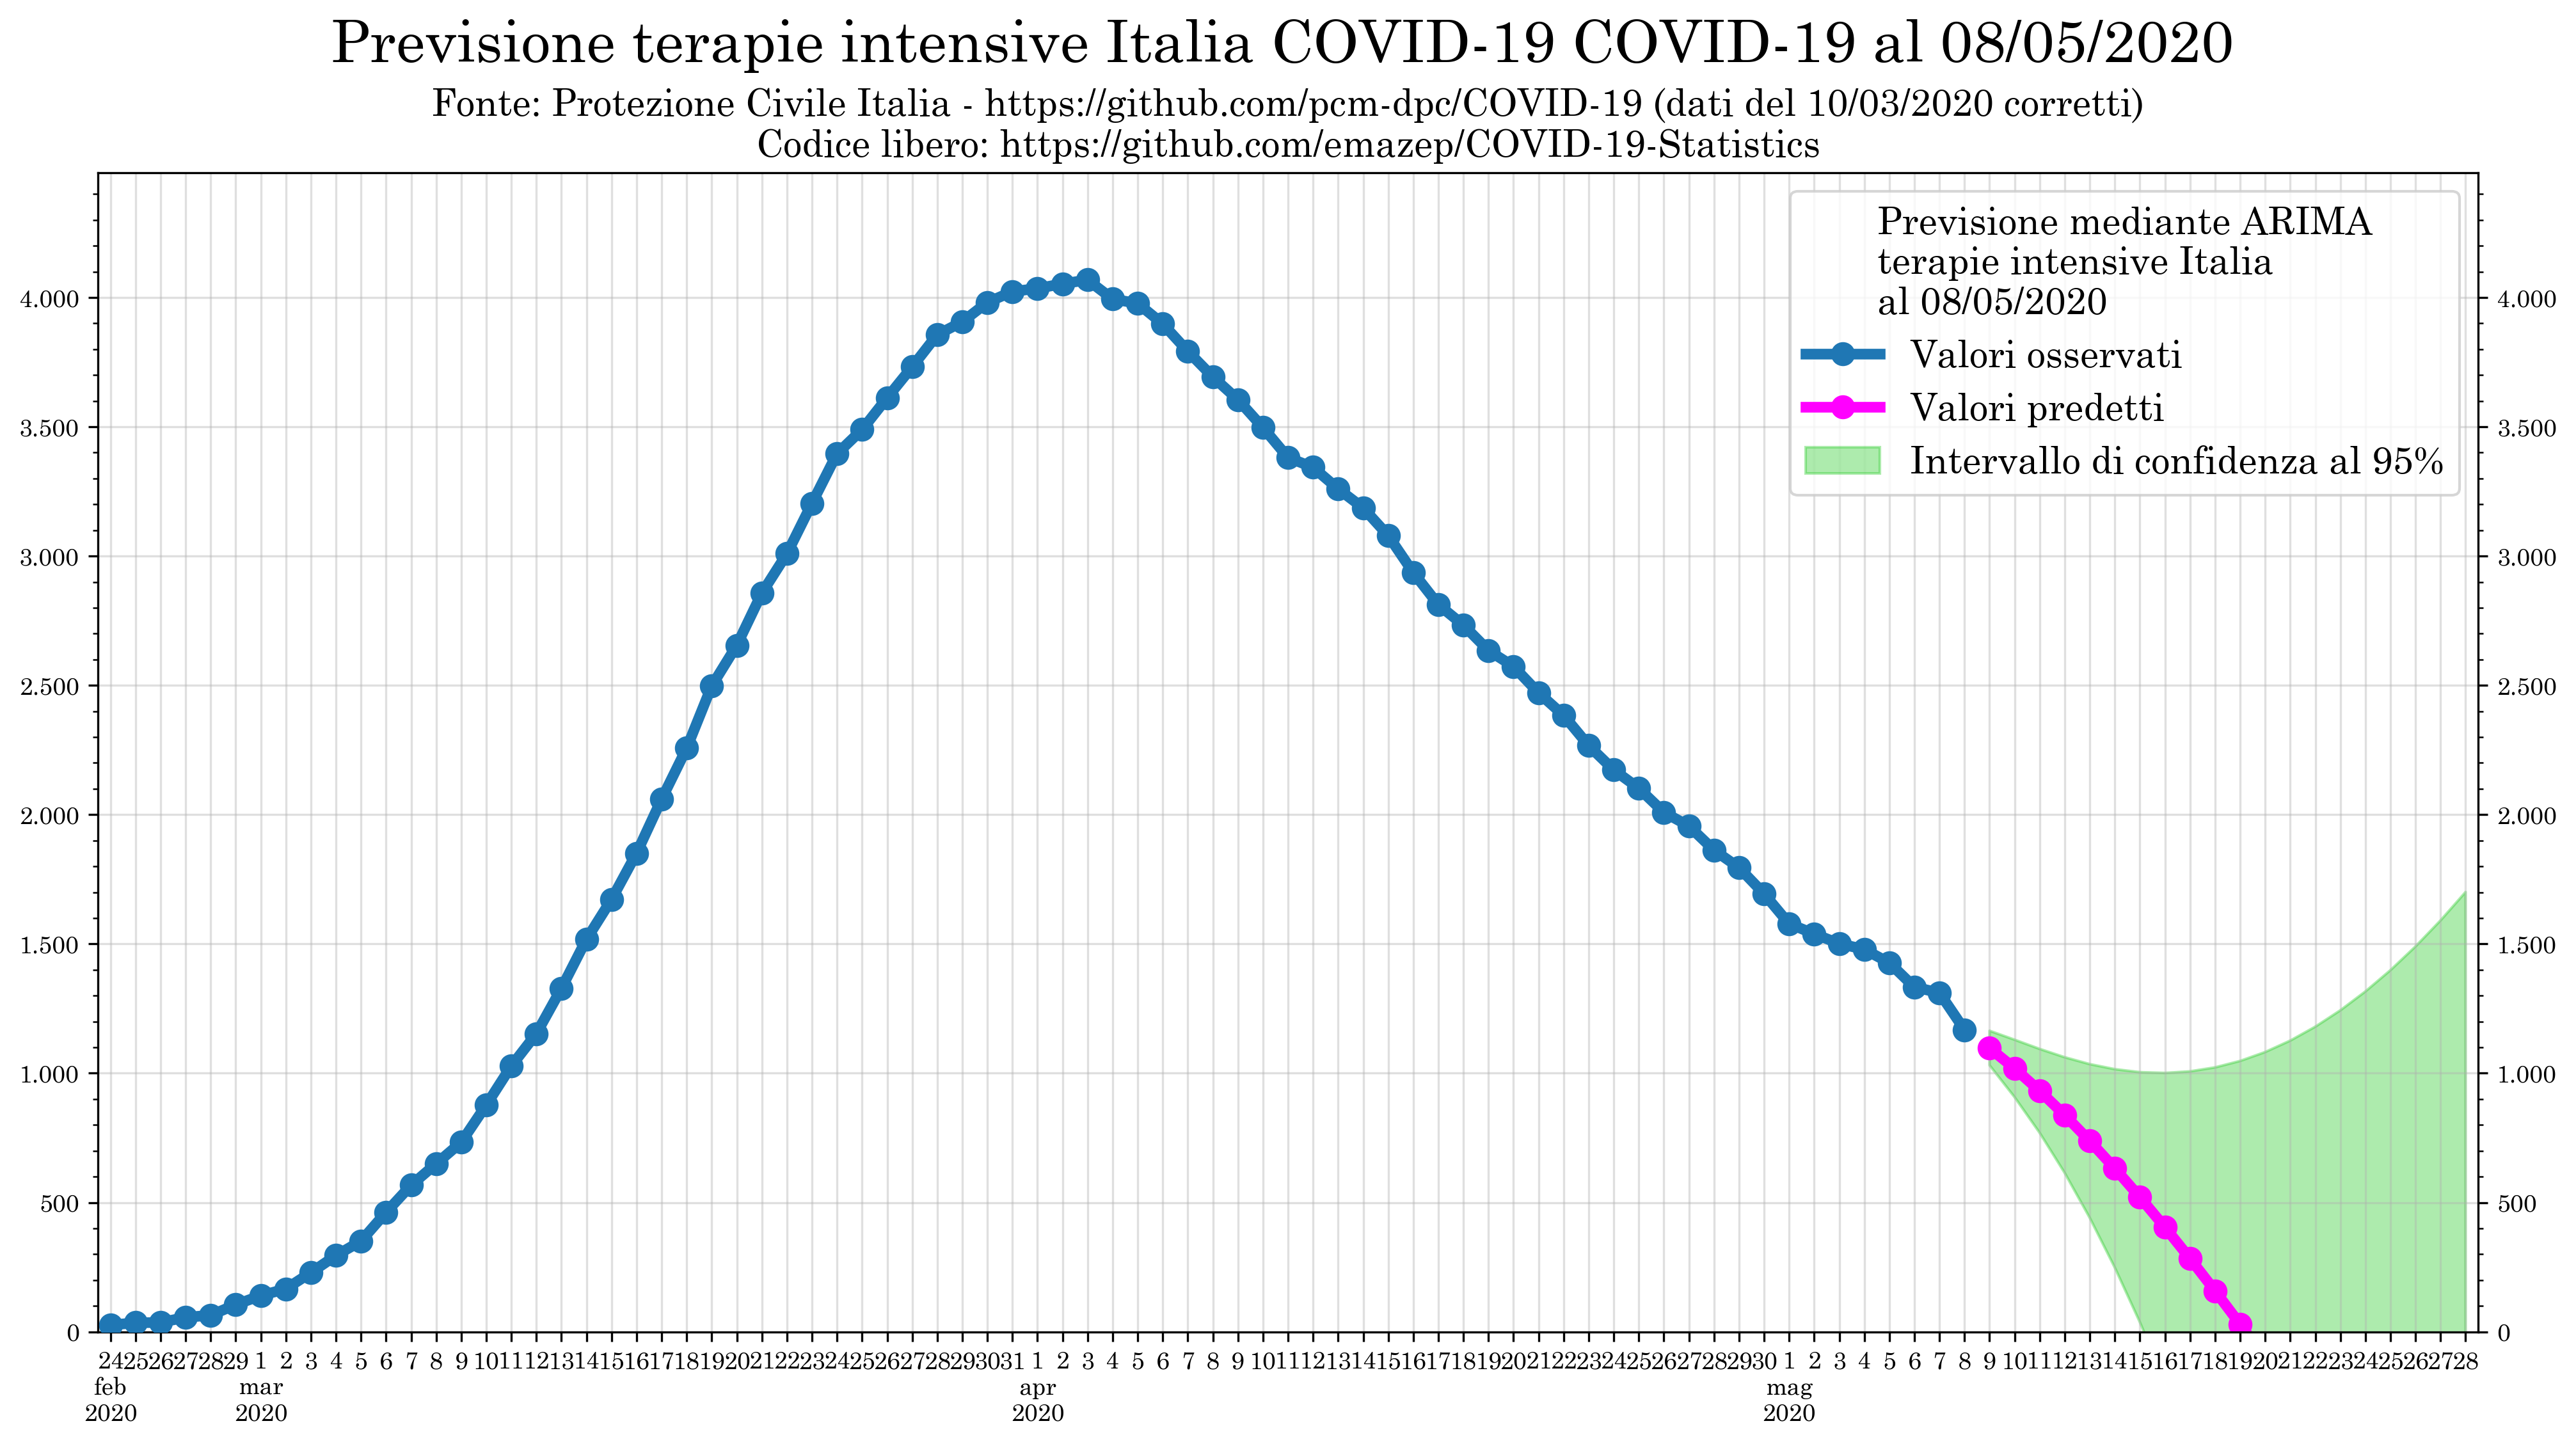

<Figure size 1800x1200 with 0 Axes>

In [264]:
FROM = date.fromisoformat('2020-04-03')
#ds = ds_it[FROM:]
ds = ds_it
column = 'terapia_intensiva'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=20)
fig_ARIMA_ICU = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'terapie intensive Italia COVID-19', 'terapie intensive Italia', y_major=500, y_minor=100
)

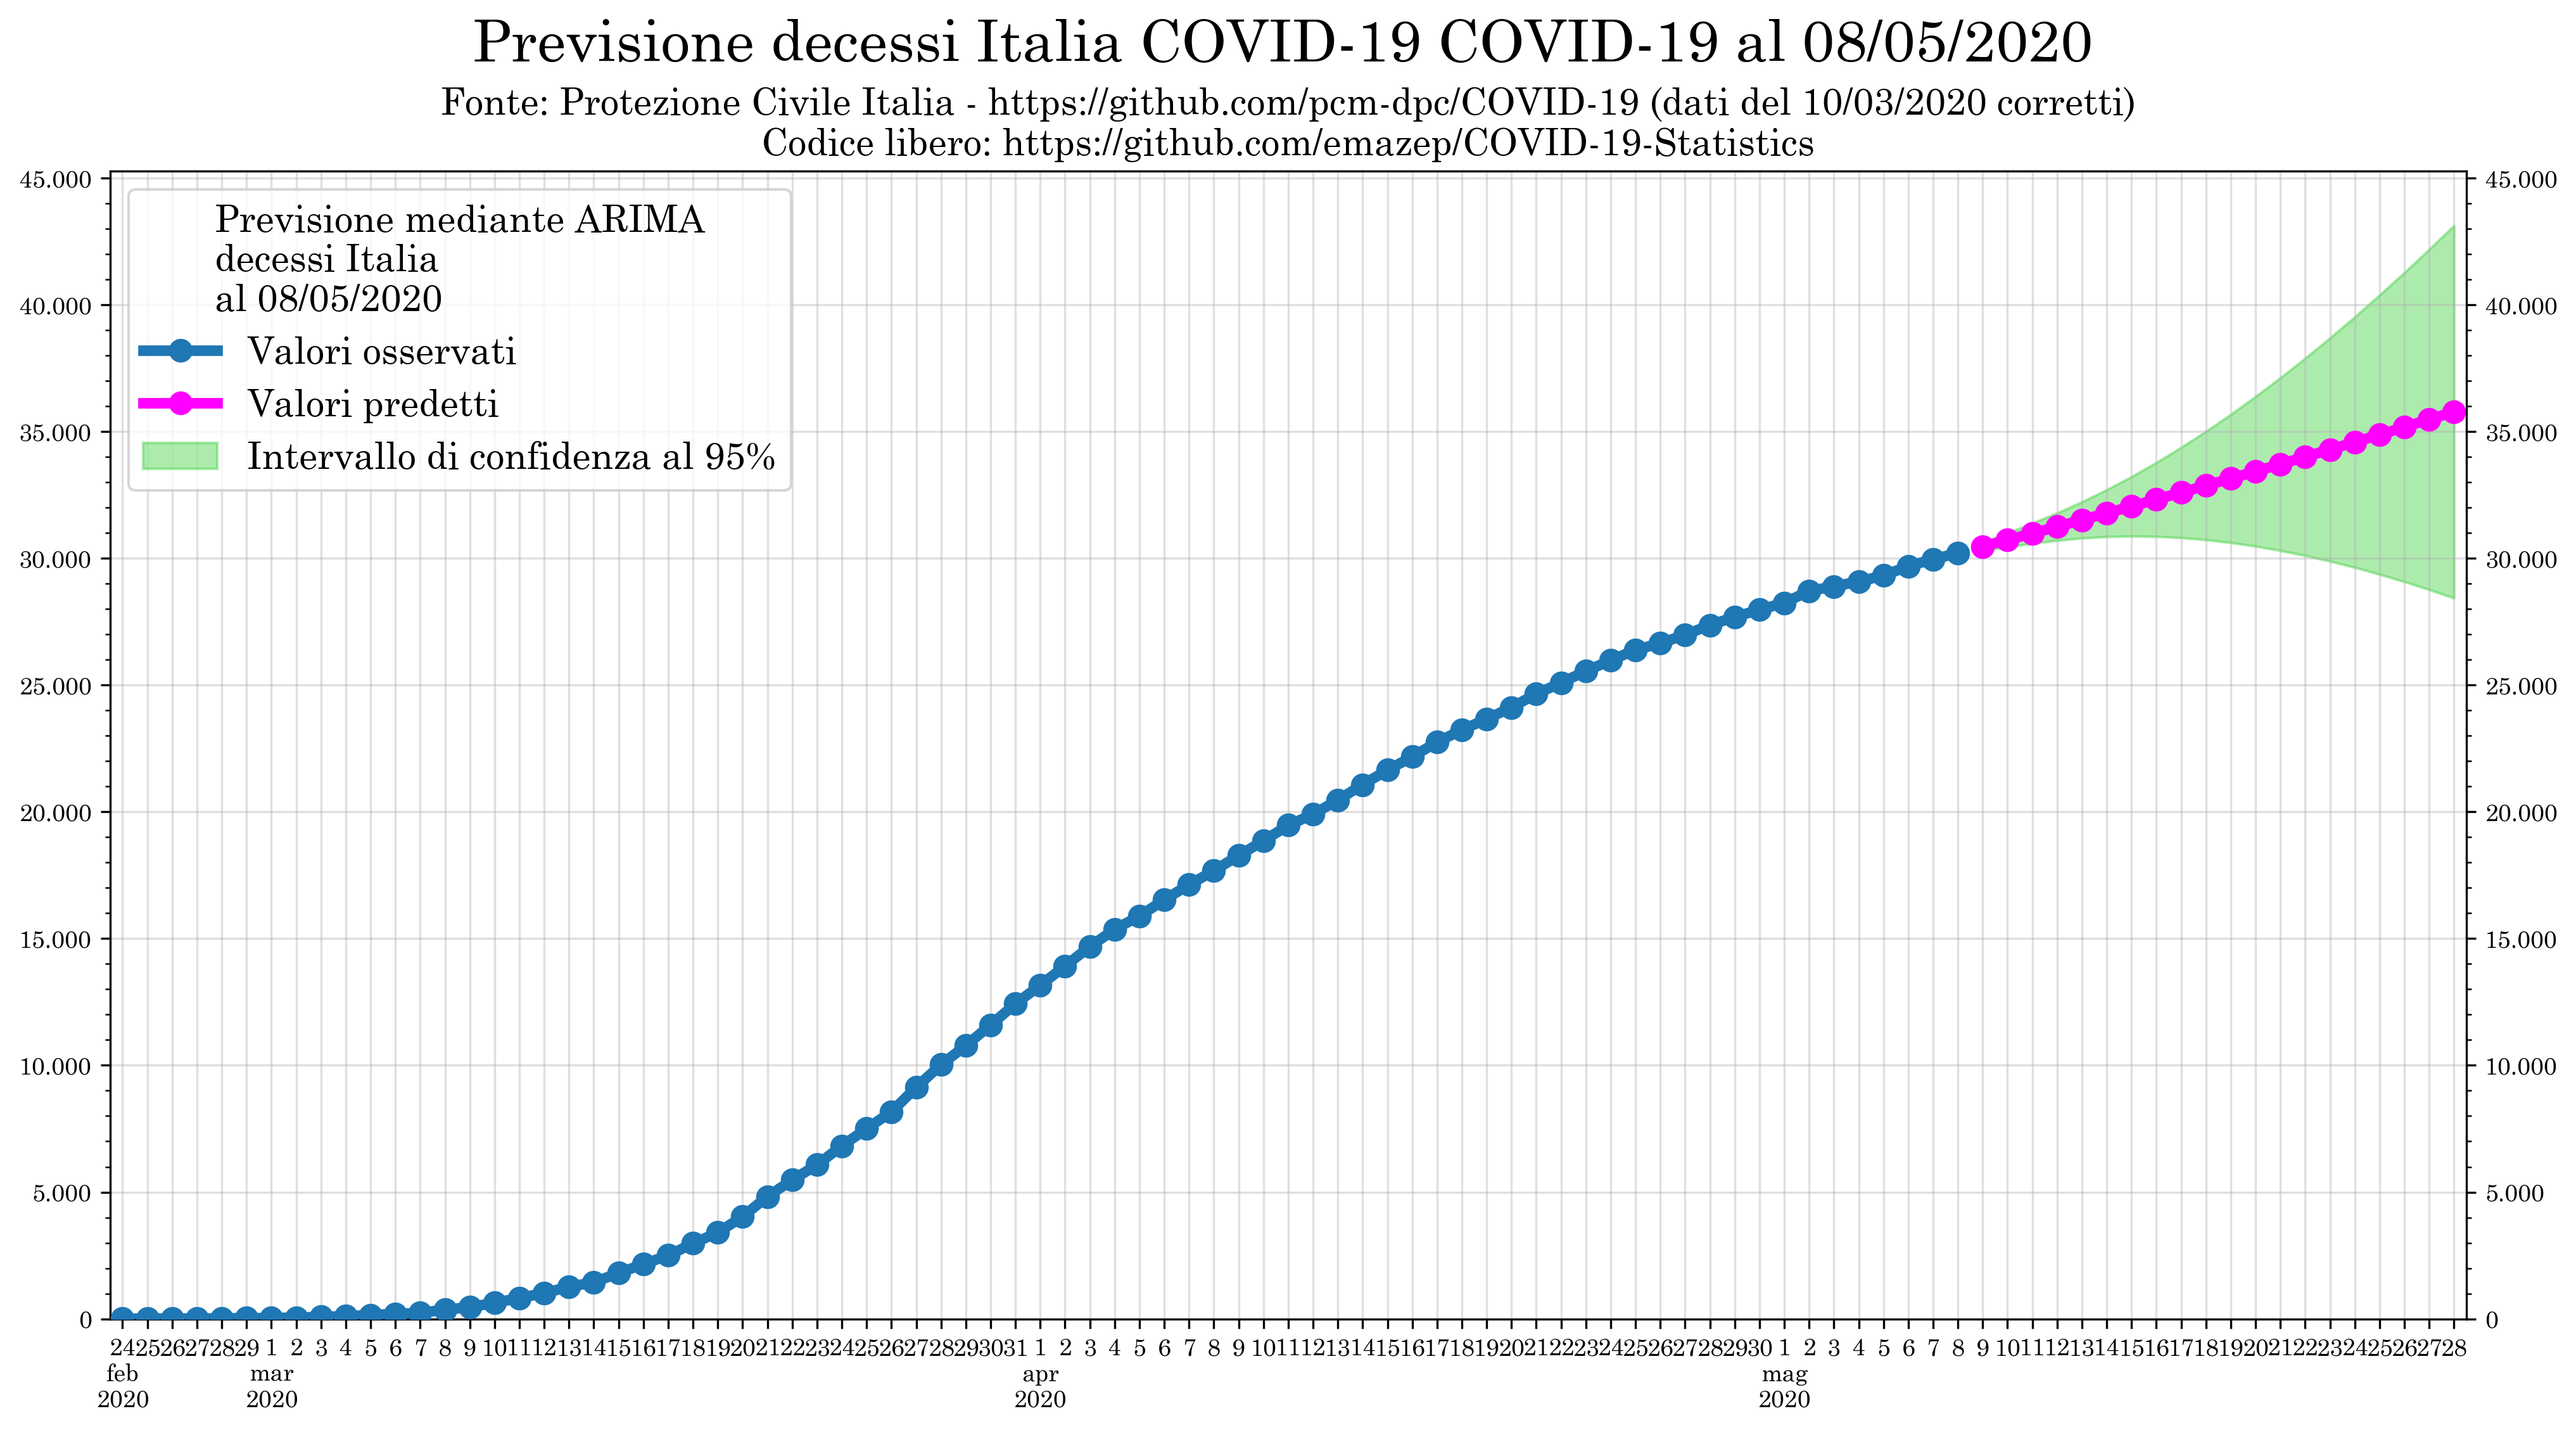

<Figure size 1800x1200 with 0 Axes>

In [265]:
ds = ds_it
column = 'deceduti'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=20)
fig_ARIMA_deaths = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'decessi Italia COVID-19', 'decessi Italia', y_major=5000, y_minor=1000
)

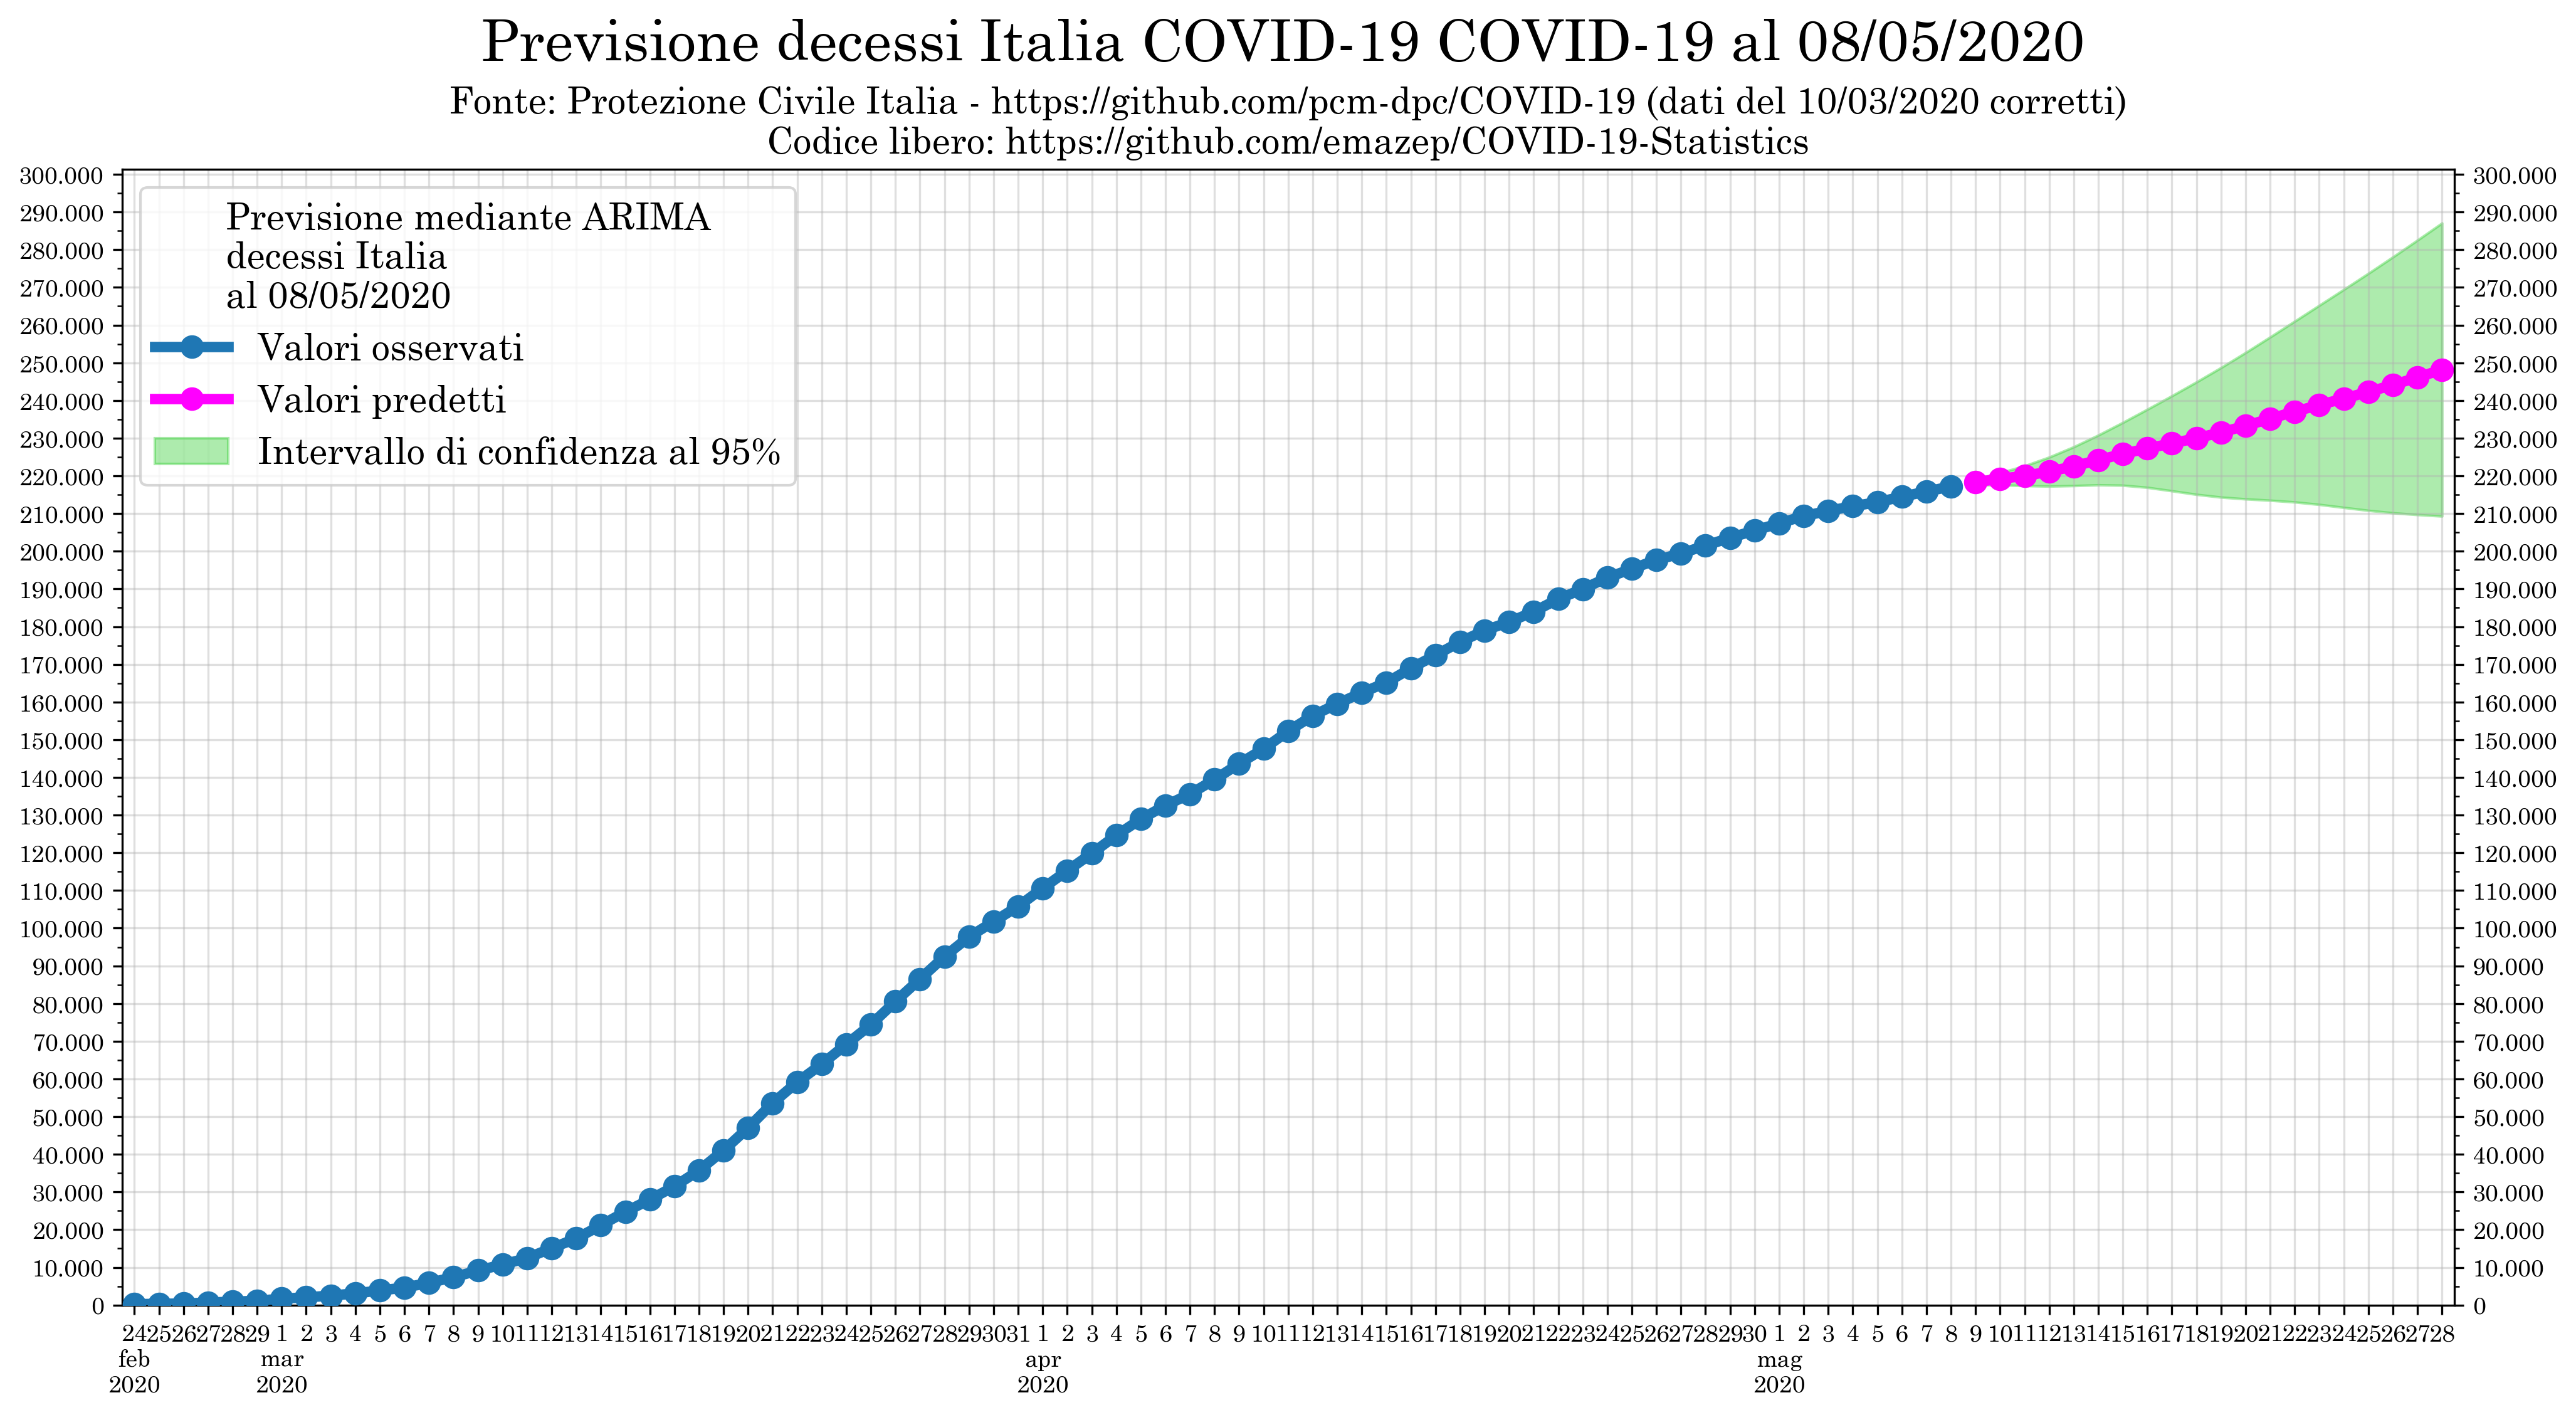

<Figure size 1800x1200 with 0 Axes>

In [266]:
ds = ds_it
column = 'totale_casi'
x_pred, predictions, conf_int = make_arima_pred(ds, column, periods=20)
fig_ARIMA_totale_casi = plot_predictions(
    ds, column, x_pred, predictions, conf_int, 'decessi Italia COVID-19', 'decessi Italia', y_major=10000, y_minor=5000
)